In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/classic-model/classic_model.sav
/kaggle/input/model-data/Y.csv
/kaggle/input/model-data/Test_df.csv
/kaggle/input/model-data/X.csv
/kaggle/input/shap-pickle/shap.pickle
/kaggle/input/x-w-id/X_w_ID.csv
/kaggle/input/model-ocp7/SMOTE_model-2.sav
/kaggle/input/home-credit-default-risk/sample_submission.csv
/kaggle/input/home-credit-default-risk/bureau_balance.csv
/kaggle/input/home-credit-default-risk/POS_CASH_balance.csv
/kaggle/input/home-credit-default-risk/application_train.csv
/kaggle/input/home-credit-default-risk/HomeCredit_columns_description.csv
/kaggle/input/home-credit-default-risk/application_test.csv
/kaggle/input/home-credit-default-risk/previous_application.csv
/kaggle/input/home-credit-default-risk/credit_card_balance.csv
/kaggle/input/home-credit-default-risk/installments_payments.csv
/kaggle/input/home-credit-default-risk/bureau.csv
/kaggle/input/ocp7-data/df.csv


In [2]:
import lightgbm
lightgbm.__version__

'3.3.2'

In [3]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import gc
import time
from contextlib import contextmanager
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import re
import random
import shap
import pickle
import joblib
from matplotlib.pyplot import figure

## Sommaire:
* [EDA](#EDA)
* [Features Importance and Preprocessing](#Features_Importance)
* [MODEL](#MODEL)
* [Local Interpretation](#Local_Interpretation)

In [4]:
print(os.listdir("../input/"))

['classic-model', 'model-data', 'shap-pickle', 'x-w-id', 'model-ocp7', 'home-credit-default-risk', 'ocp7-data']


In [16]:
train_data = pd.read_csv('../input/home-credit-default-risk/application_train.csv')
print('Training data shape: ', train_data.shape)
train_data.head()

Training data shape:  (307511, 122)


SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0      100002       1         Cash loans           M            N   
1      100003       0         Cash loans           F            N   
2      100004       0    Revolving loans           M            Y   
3      100006       0         Cash loans           F            N   
4      100007       0         Cash loans           M            N   

  FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
0               Y             0          202500.0    406597.5      24700.5   
1               N             0          270000.0   1293502.5      35698.5   
2               Y             0           67500.0    135000.0       6750.0   
3               Y             0          135000.0    312682.5      29686.5   
4               Y             0          121500.0    513000.0      21865.5   

   ...  FLAG_DOCUMENT_18 FLAG_DOCUMENT_19 FLAG_DOCUMENT_20 FLAG_DOCUMENT_21  \
0  ...                 0                0                0                0   
1  ...                 0                0                0                0   
2  ...                 0                0                0                0   
3  ...                 0                0                0                0   
4  ...                 0                0                0                0   

  AMT_REQ_CREDIT_BUREAU_HOUR AMT_REQ_CREDIT_BUREAU_DAY  \
0                        0.0                       0.0   
1                        0.0                       0.0   
2                        0.0                       0.0   
3                        NaN                       NaN   
4                        0.0                       0.0   

   AMT_REQ_CREDIT_BUREAU_WEEK  AMT_REQ_CREDIT_BUREAU_MON  \
0                         0.0                        0.0   
1                         0.0                        0.0   
2                         0.0                        0.0   
3                         NaN                        NaN   
4                         0.0                        0.0   

   AMT_REQ_CREDIT_BUREAU_QRT  AMT_REQ_CREDIT_BUREAU_YEAR  
0                        0.0                         1.0  
1                        0.0                         0.0  
2                        0.0                         0.0  
3                        NaN                         NaN  
4                        0.0                         0.0  

[5 rows x 122 columns]

In [17]:
test_data = pd.read_csv('../input/home-credit-default-risk/application_test.csv')
print('Testing data shape: ', test_data.shape)
test_data.head()

Testing data shape:  (48744, 121)


SK_ID_CURR NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR FLAG_OWN_REALTY  \
0      100001         Cash loans           F            N               Y   
1      100005         Cash loans           M            N               Y   
2      100013         Cash loans           M            Y               Y   
3      100028         Cash loans           F            N               Y   
4      100038         Cash loans           M            Y               N   

   CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0             0          135000.0    568800.0      20560.5         450000.0   
1             0           99000.0    222768.0      17370.0         180000.0   
2             0          202500.0    663264.0      69777.0         630000.0   
3             2          315000.0   1575000.0      49018.5        1575000.0   
4             1          180000.0    625500.0      32067.0         625500.0   

   ... FLAG_DOCUMENT_18 FLAG_DOCUMENT_19 FLAG_DOCUMENT_20 FLAG_DOCUMENT_21  \
0  ...                0                0                0                0   
1  ...                0                0                0                0   
2  ...                0                0                0                0   
3  ...                0                0                0                0   
4  ...                0                0                0                0   

  AMT_REQ_CREDIT_BUREAU_HOUR  AMT_REQ_CREDIT_BUREAU_DAY  \
0                        0.0                        0.0   
1                        0.0                        0.0   
2                        0.0                        0.0   
3                        0.0                        0.0   
4                        NaN                        NaN   

   AMT_REQ_CREDIT_BUREAU_WEEK  AMT_REQ_CREDIT_BUREAU_MON  \
0                         0.0                        0.0   
1                         0.0                        0.0   
2                         0.0                        0.0   
3                         0.0                        0.0   
4                         NaN                        NaN   

   AMT_REQ_CREDIT_BUREAU_QRT  AMT_REQ_CREDIT_BUREAU_YEAR  
0                        0.0                         0.0  
1                        0.0                         3.0  
2                        1.0                         4.0  
3                        0.0                         3.0  
4                        NaN                         NaN  

[5 rows x 121 columns]

# <a name ="EDA"> EDA  </a>

In [7]:
print("The application_train.csv has {} entires.".format(train_data.shape))
print("The application_test.csv has {} entires.".format(test_data.shape))

The application_train.csv has (307511, 122) entires.
The application_test.csv has (48744, 121) entires.


In [8]:
print('train data :',len(train_data)/(len(train_data)+ len(test_data))*100, '%')
print('test data :',len(test_data)/(len(train_data)+ len(test_data))*100, '%')

train data : 86.31766571697239 %
test data : 13.682334283027606 %


**Train Data :**

In [9]:
df = train_data
columns_list = df.columns.tolist()   
total = len(df)
df_taux_values = df.melt(id_vars = "SK_ID_CURR" ) 
df_taux_values = df.melt(id_vars = 'SK_ID_CURR', value_vars = columns_list )
df_taux_values['freq'] = df_taux_values.groupby('variable')['value'].transform('count')     
df_taux_values = df_taux_values.groupby('variable').mean('freq')    
df_taux_values['Tot_Freq'] = total   
df_taux_values['freq/Tot_Freq'] = df_taux_values.freq/df_taux_values.Tot_Freq      
df_taux_values = df_taux_values.reset_index()

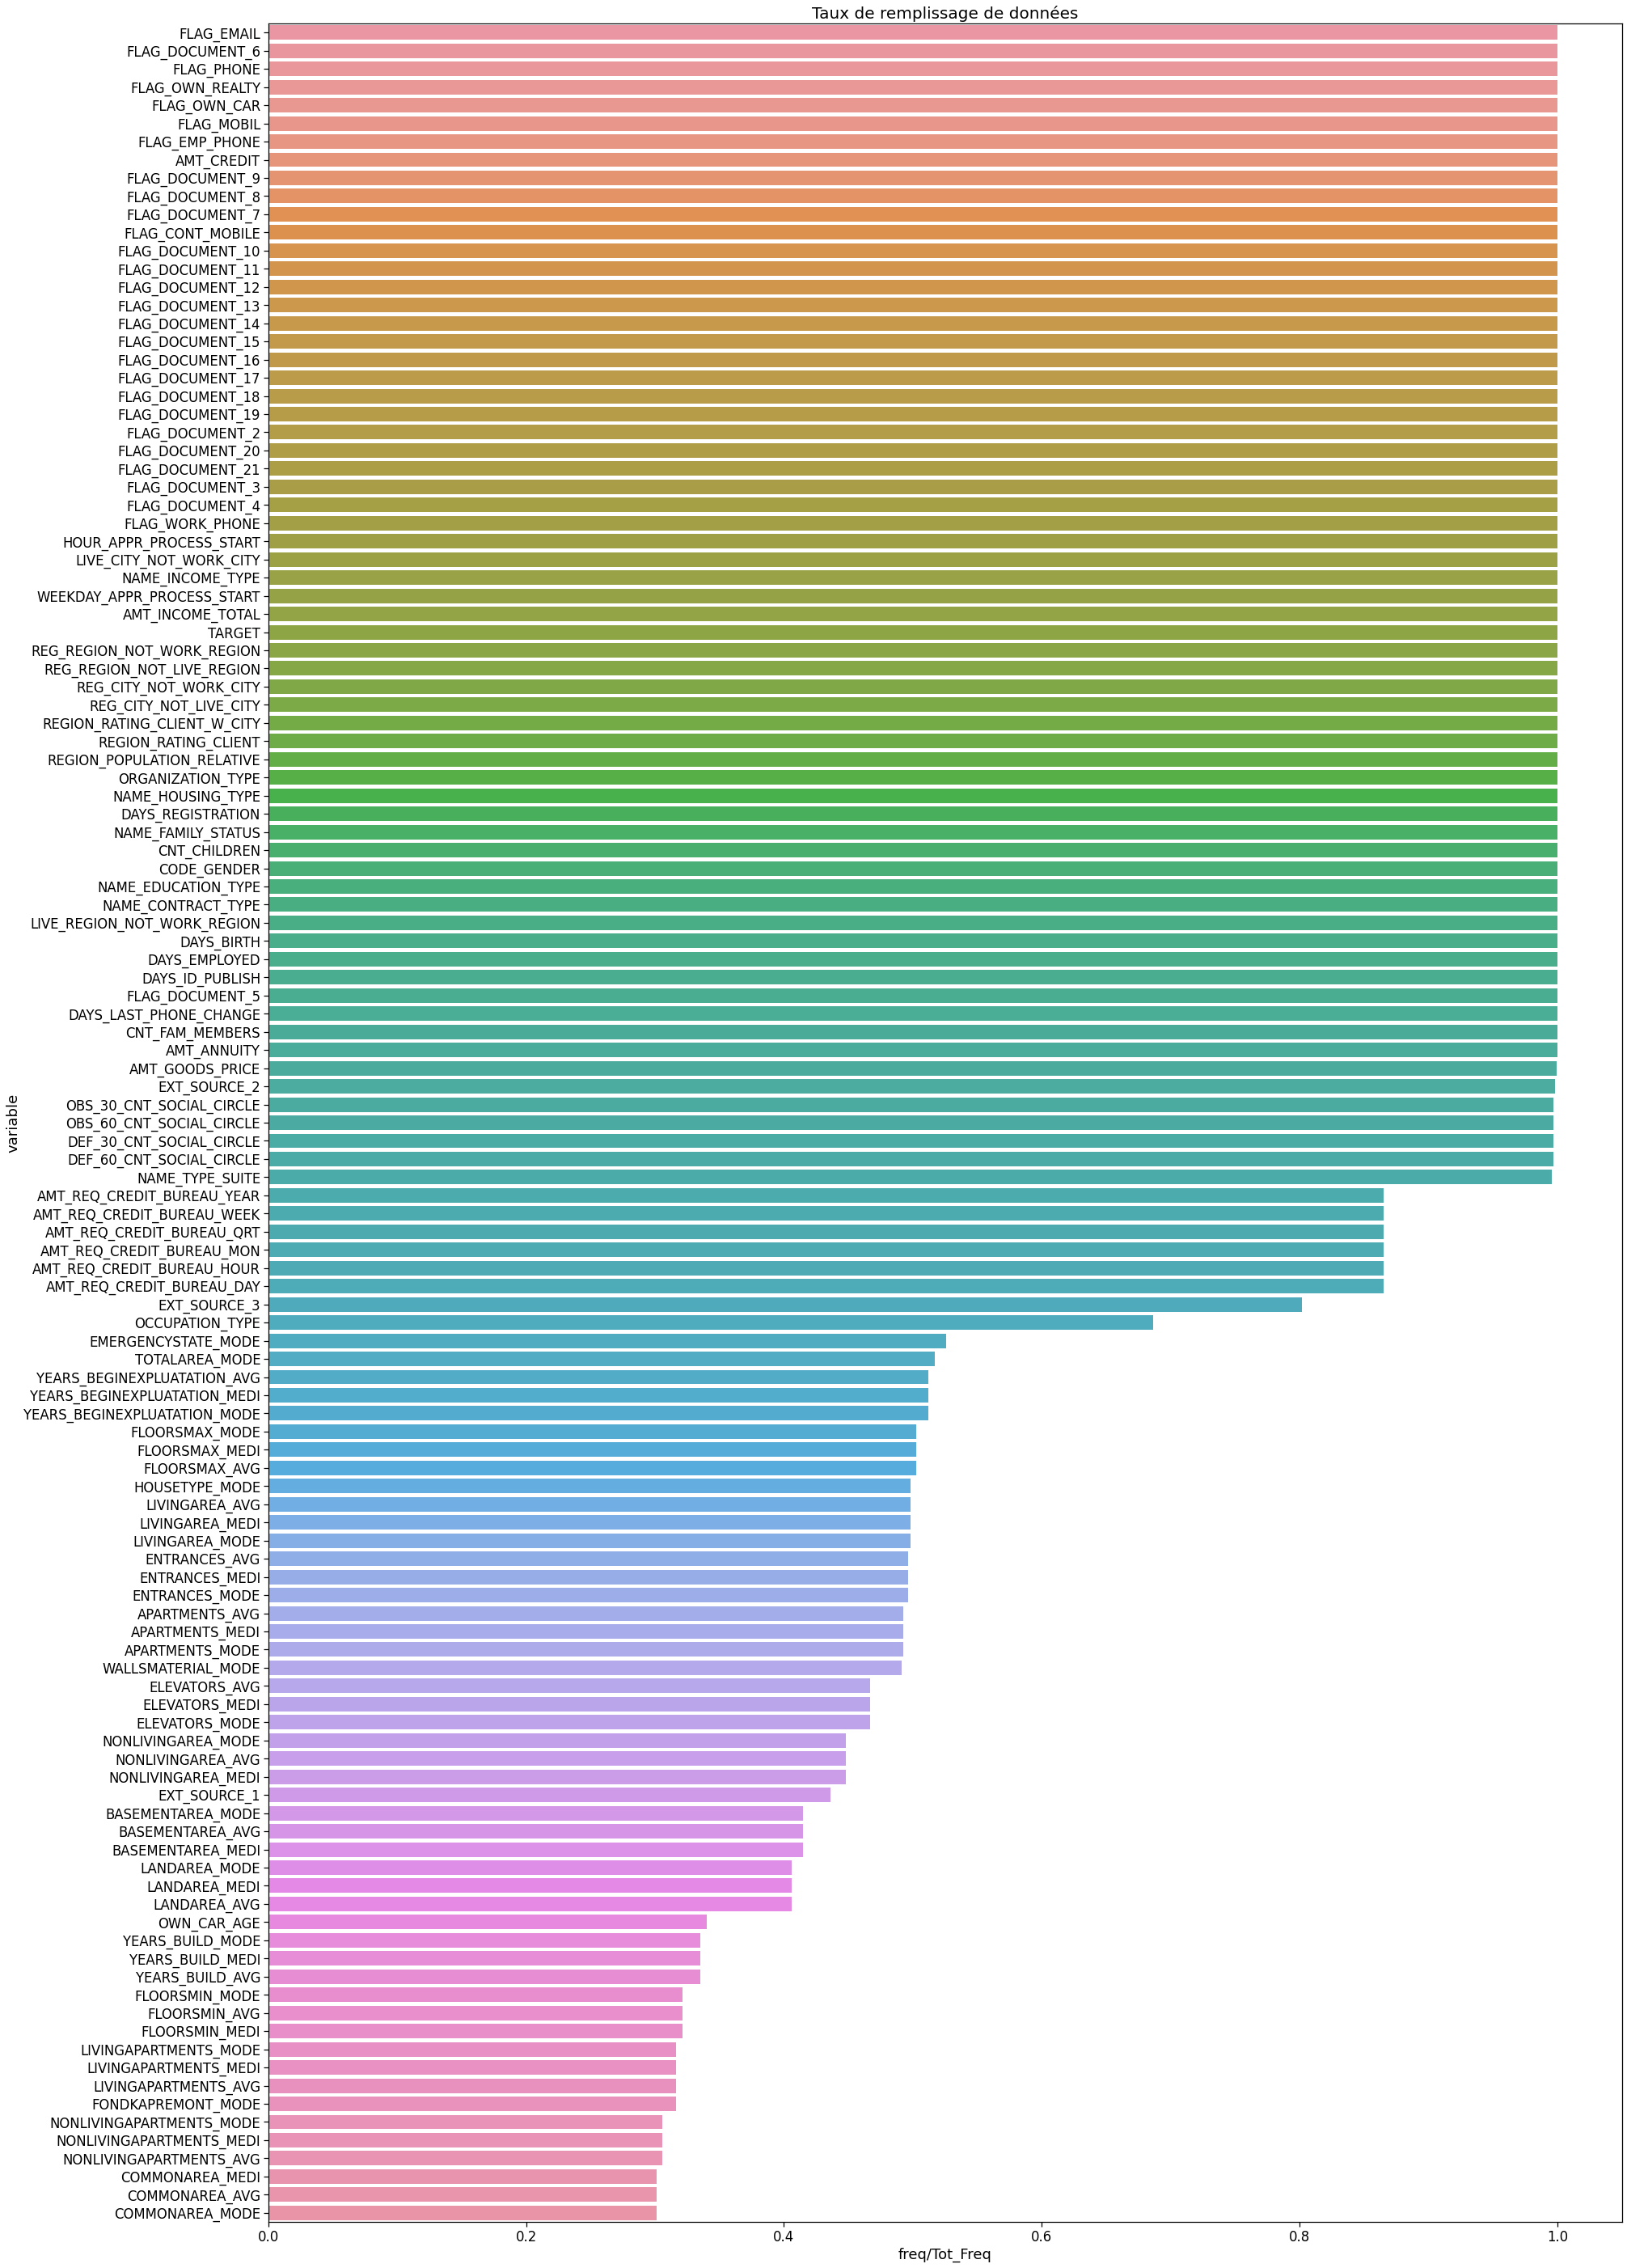

In [10]:
plt.figure(figsize = (30,50))
sns.set_context("notebook", font_scale=1.5)
s1 = sns.barplot(y = 'variable', x = 'freq/Tot_Freq', data = df_taux_values.sort_values(by=['freq'], ascending=False))
plt.title("Taux de remplissage de données", size=20)
plt.show()

In [18]:
train_data['TARGET'].value_counts()

0    282686
1     24825
Name: TARGET, dtype: int64

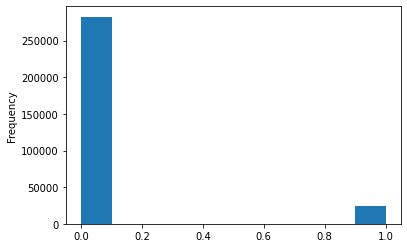

In [19]:
train_data['TARGET'].astype(int).plot.hist();

<AxesSubplot:xlabel='CODE_GENDER', ylabel='count'>

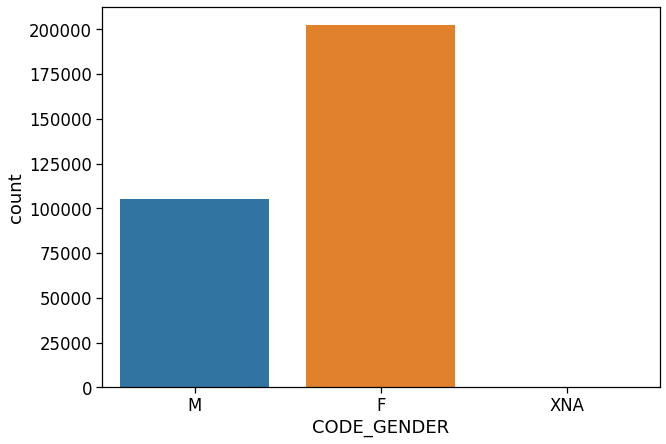

In [13]:
fig, ax = plt.subplots(figsize=(10,7))
sns.countplot(x='CODE_GENDER',data=train_data)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17]),
 [Text(0, 0, 'Laborers'),
  Text(1, 0, 'Core staff'),
  Text(2, 0, 'Accountants'),
  Text(3, 0, 'Managers'),
  Text(4, 0, 'Drivers'),
  Text(5, 0, 'Sales staff'),
  Text(6, 0, 'Cleaning staff'),
  Text(7, 0, 'Cooking staff'),
  Text(8, 0, 'Private service staff'),
  Text(9, 0, 'Medicine staff'),
  Text(10, 0, 'Security staff'),
  Text(11, 0, 'High skill tech staff'),
  Text(12, 0, 'Waiters/barmen staff'),
  Text(13, 0, 'Low-skill Laborers'),
  Text(14, 0, 'Realty agents'),
  Text(15, 0, 'Secretaries'),
  Text(16, 0, 'IT staff'),
  Text(17, 0, 'HR staff')])

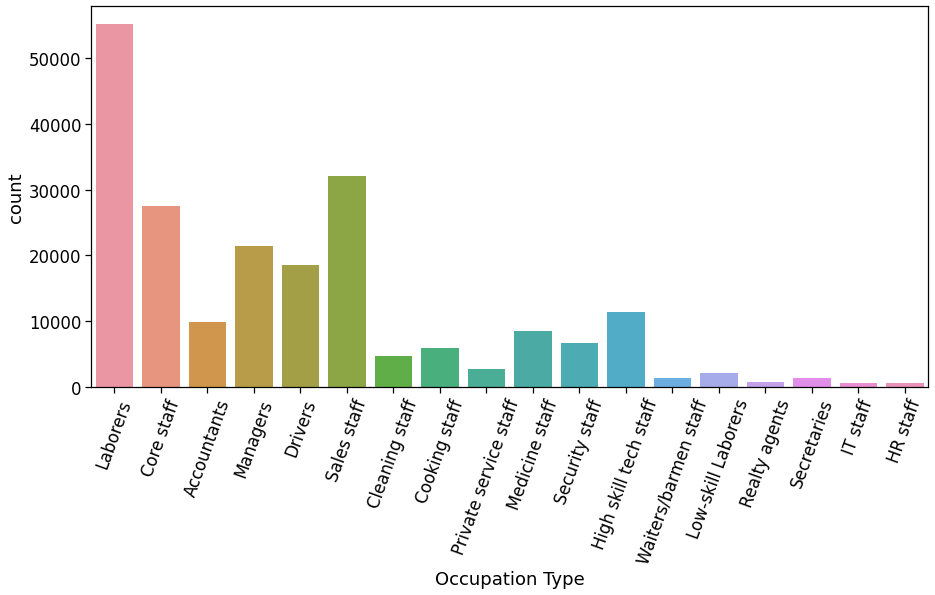

In [14]:
fig, ax = plt.subplots(figsize=(15,7))
sns.countplot(x='OCCUPATION_TYPE',data=train_data)
plt.xlabel("Occupation Type")
plt.xticks(rotation=70)

Text(0, 0.5, 'Average Annual family income')

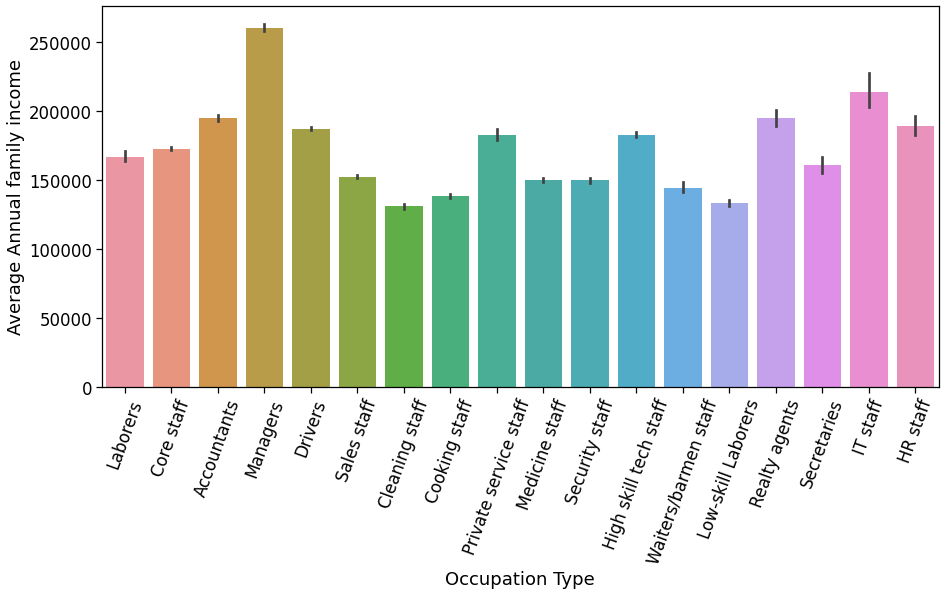

In [15]:
fig, ax = plt.subplots(figsize=(15,7))
sns.barplot(x='OCCUPATION_TYPE',y='AMT_INCOME_TOTAL',data=train_data)
plt.xticks(rotation=70)
plt.xlabel("Occupation Type")
plt.ylabel("Average Annual family income")

Text(0.5, 0, 'Occupation Type')

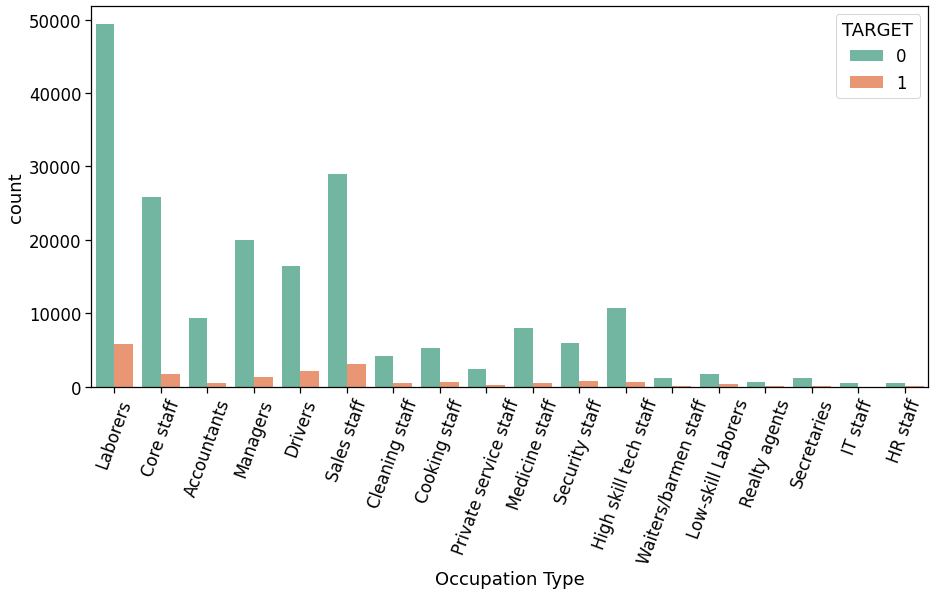

In [16]:
fig, ax = plt.subplots(figsize=(15,7))
sns.countplot(x='OCCUPATION_TYPE',hue='TARGET',data=train_data,palette="Set2")
plt.xticks(rotation=70)
plt.xlabel("Occupation Type")

In [17]:
print(max(train_data.CNT_CHILDREN))

19


Text(0.5, 0, 'Gender')

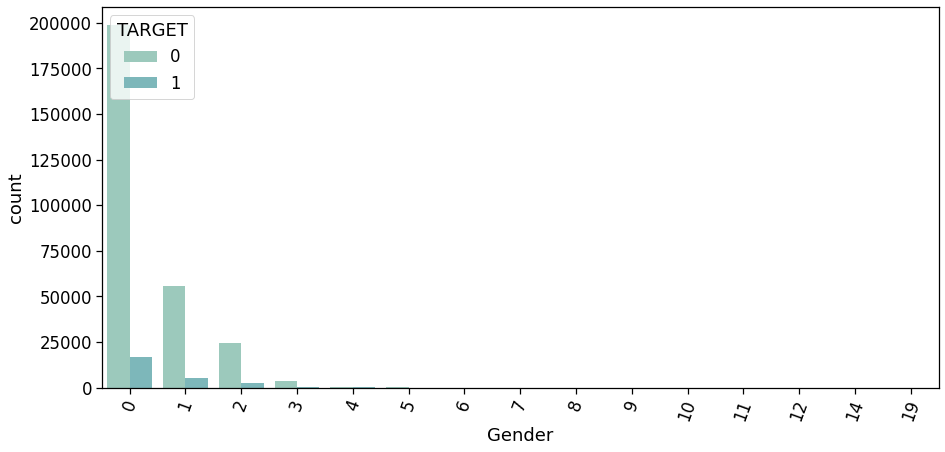

In [18]:
fig,ax = plt.subplots(figsize = (15,7))
sns.countplot(x='CNT_CHILDREN',data=train_data,hue='TARGET',palette=sns.color_palette("GnBu_d"))
plt.xticks(rotation=70)
plt.xlabel("Gender")

Text(0.5, 0, 'Gender')

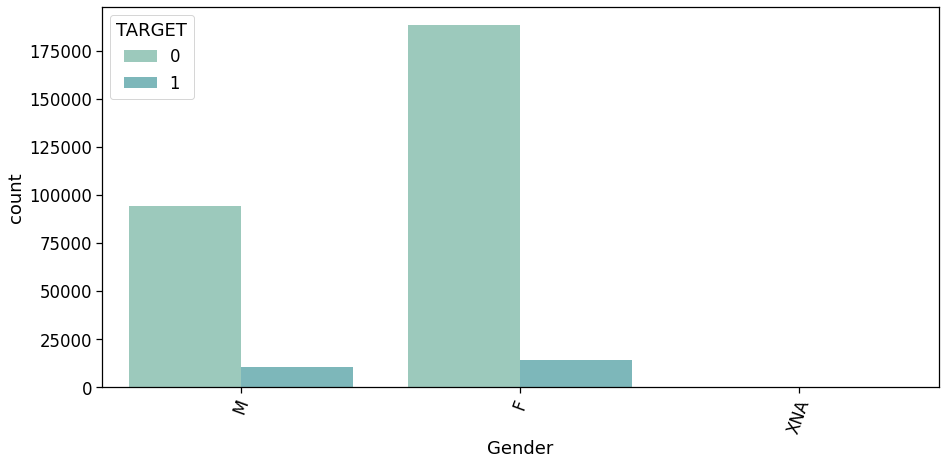

In [19]:
fig,ax = plt.subplots(figsize = (15,7))
sns.countplot(x='CODE_GENDER',data=train_data,hue='TARGET',palette=sns.color_palette("GnBu_d"))
plt.xticks(rotation=70)
plt.xlabel("Gender")

**Test Data**

In [20]:
df = test_data
columns_list = df.columns.tolist()   
total = len(df)
df_taux_values = df.melt(id_vars = "SK_ID_CURR" ) 
df_taux_values = df.melt(id_vars = 'SK_ID_CURR', value_vars = columns_list )
df_taux_values['freq'] = df_taux_values.groupby('variable')['value'].transform('count')     
df_taux_values = df_taux_values.groupby('variable').mean('freq')    
df_taux_values['Tot_Freq'] = total   
df_taux_values['freq/Tot_Freq'] = df_taux_values.freq/df_taux_values.Tot_Freq      
df_taux_values = df_taux_values.reset_index()

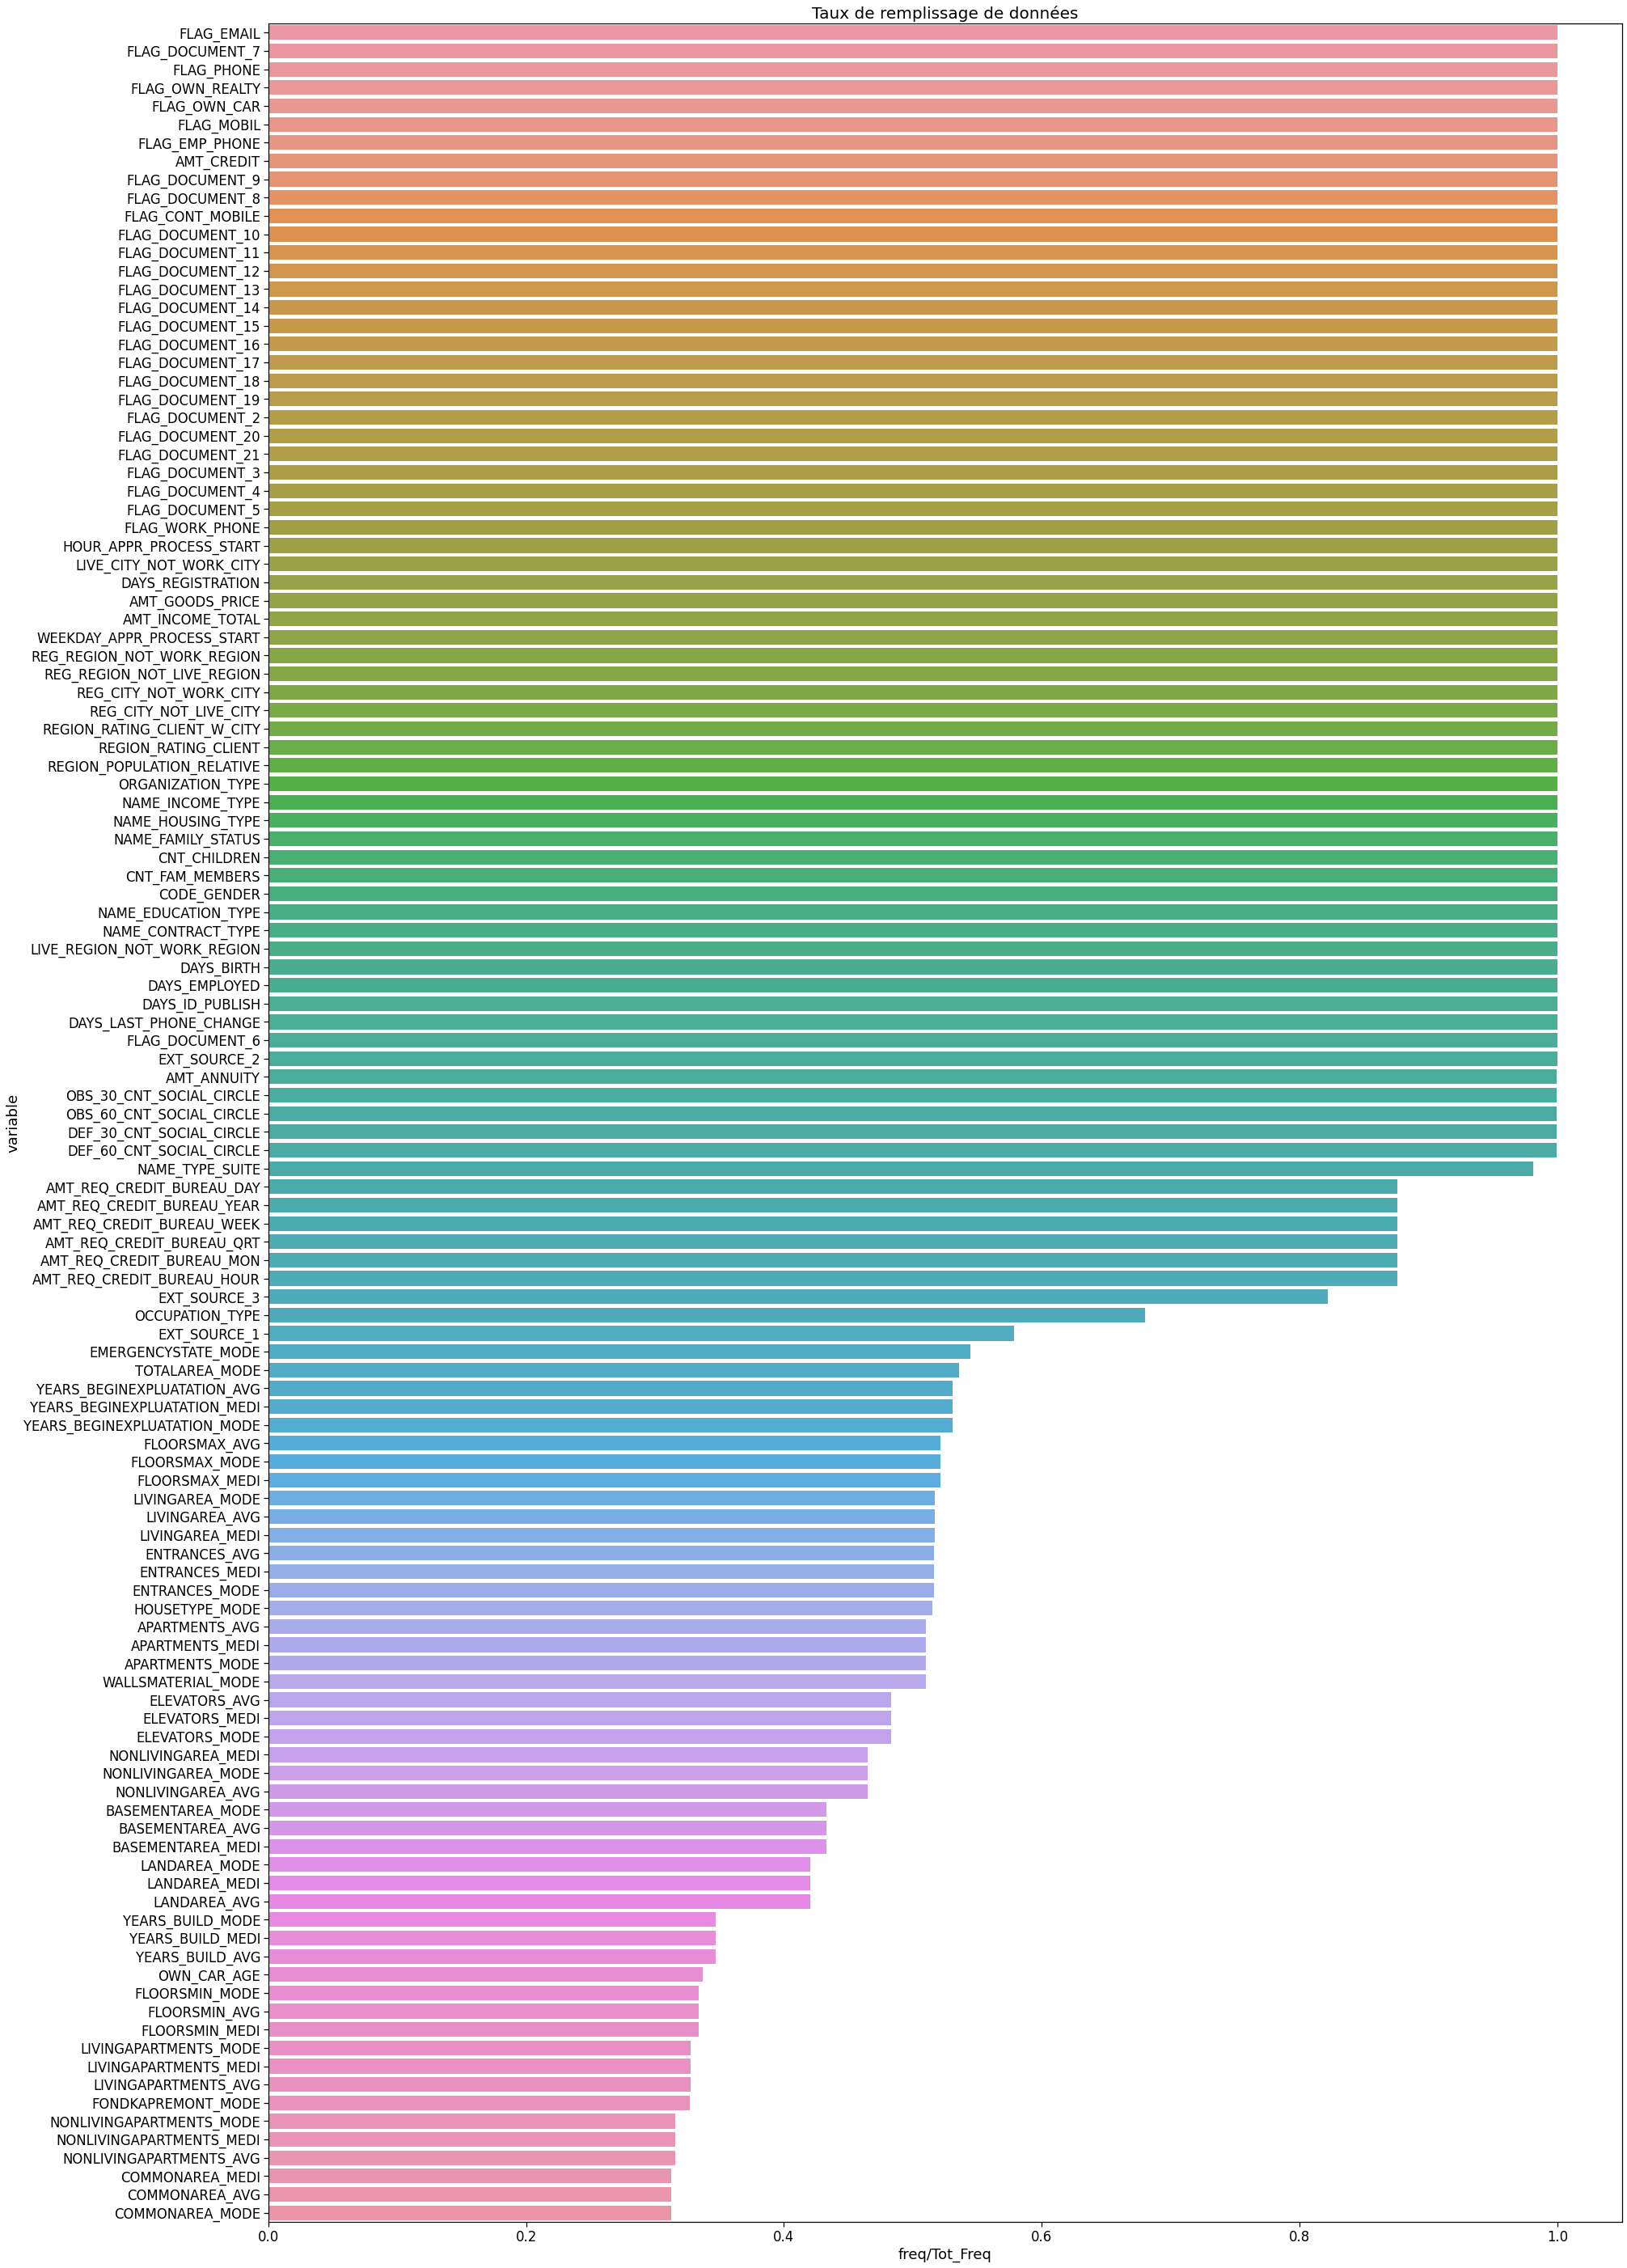

In [21]:
plt.figure(figsize = (30,50))
sns.set_context("notebook", font_scale=1.5)
s1 = sns.barplot(y = 'variable', x = 'freq/Tot_Freq', data = df_taux_values.sort_values(by=['freq'], ascending=False))
plt.title("Taux de remplissage de données", size=20)
plt.show()

In [22]:

data = pd.read_csv('../input/home-credit-default-risk/application_train.csv')
data = data.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
print(data.columns)

Index(['SK_ID_CURR', 'TARGET', 'NAME_CONTRACT_TYPE', 'CODE_GENDER',
       'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL',
       'AMT_CREDIT', 'AMT_ANNUITY',
       ...
       'FLAG_DOCUMENT_18', 'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_20',
       'FLAG_DOCUMENT_21', 'AMT_REQ_CREDIT_BUREAU_HOUR',
       'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_WEEK',
       'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT',
       'AMT_REQ_CREDIT_BUREAU_YEAR'],
      dtype='object', length=122)


# <a name ="Features_Importance"> Features Importance and Preprocessing  </a>

In [23]:
# HOME CREDIT DEFAULT RISK COMPETITION
# Most features are created by applying min, max, mean, sum and var functions to grouped tables. 
# Little feature selection is done and overfitting might be a problem since many features are related.
# The following key ideas were used:
# - Divide or subtract important features to get rates (like annuity and income)
# - In Bureau Data: create specific features for Active credits and Closed credits
# - In Previous Applications: create specific features for Approved and Refused applications
# - Modularity: one function for each table (except bureau_balance and application_test)
# - One-hot encoding for categorical features
# All tables are joined with the application DF using the SK_ID_CURR key (except bureau_balance).
# You can use LightGBM with KFold or Stratified KFold.

# Update 16/06/2018:
# - Added Payment Rate feature
# - Removed index from features
# - Use standard KFold CV (not stratified)

import numpy as np
import pandas as pd
import gc
import time
from contextlib import contextmanager
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import KFold, StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

@contextmanager
def timer(title):
    t0 = time.time()
    yield
    print("{} - done in {:.0f}s".format(title, time.time() - t0))

# One-hot encoding for categorical columns with get_dummies
def one_hot_encoder(df, nan_as_category = True):
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns= categorical_columns, dummy_na= nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns

import re

# Preprocess application_train.csv and application_test.csv
def application_train_test(num_rows = None, nan_as_category = False):
    # Read data and merge
    
    
    df = pd.read_csv('../input/home-credit-default-risk/application_train.csv', nrows= num_rows)
    df = df.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
    test_df = pd.read_csv('../input/home-credit-default-risk/application_test.csv', nrows= num_rows)
    test_df = test_df.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
    print("Train samples: {}, test samples: {}".format(len(df), len(test_df)))
    df = df.append(test_df).reset_index()
    # Optional: Remove 4 applications with XNA CODE_GENDER (train set)
    df = df[df['CODE_GENDER'] != 'XNA']
    
    # Categorical features with Binary encode (0 or 1; two categories)
    for bin_feature in ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']:
        df[bin_feature], uniques = pd.factorize(df[bin_feature])
    # Categorical features with One-Hot encode
    df, cat_cols = one_hot_encoder(df, nan_as_category)
    
    # NaN values for DAYS_EMPLOYED: 365.243 -> nan
    df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace= True)
    # Some simple new features (percentages)
    df['DAYS_EMPLOYED_PERC'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
    df['INCOME_CREDIT_PERC'] = df['AMT_INCOME_TOTAL'] / df['AMT_CREDIT']
    df['INCOME_PER_PERSON'] = df['AMT_INCOME_TOTAL'] / df['CNT_FAM_MEMBERS']
    df['ANNUITY_INCOME_PERC'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']
    df['PAYMENT_RATE'] = df['AMT_ANNUITY'] / df['AMT_CREDIT']
    del test_df
    gc.collect()
    return df

# Preprocess bureau.csv and bureau_balance.csv
def bureau_and_balance(num_rows = None, nan_as_category = True):
    bureau = pd.read_csv('../input/home-credit-default-risk/bureau.csv', nrows = num_rows)
    bureau = bureau.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
    bb = pd.read_csv('../input/home-credit-default-risk/bureau_balance.csv', nrows = num_rows)
    bb = bb.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
    bb, bb_cat = one_hot_encoder(bb, nan_as_category)
    bureau, bureau_cat = one_hot_encoder(bureau, nan_as_category)
    
    # Bureau balance: Perform aggregations and merge with bureau.csv
    bb_aggregations = {'MONTHS_BALANCE': ['min', 'max', 'size']}
    for col in bb_cat:
        bb_aggregations[col] = ['mean']
    bb_agg = bb.groupby('SK_ID_BUREAU').agg(bb_aggregations)
    bb_agg.columns = pd.Index([e[0] + "_" + e[1].upper() for e in bb_agg.columns.tolist()])
    bureau = bureau.join(bb_agg, how='left', on='SK_ID_BUREAU')
    bureau.drop(['SK_ID_BUREAU'], axis=1, inplace= True)
    del bb, bb_agg
    gc.collect()
    
    # Bureau and bureau_balance numeric features
    num_aggregations = {
        'DAYS_CREDIT': ['min', 'max', 'mean', 'var'],
        'DAYS_CREDIT_ENDDATE': ['min', 'max', 'mean'],
        'DAYS_CREDIT_UPDATE': ['mean'],
        'CREDIT_DAY_OVERDUE': ['max', 'mean'],
        'AMT_CREDIT_MAX_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM_LIMIT': ['mean', 'sum'],
        'AMT_ANNUITY': ['max', 'mean'],
        'CNT_CREDIT_PROLONG': ['sum'],
        'MONTHS_BALANCE_MIN': ['min'],
        'MONTHS_BALANCE_MAX': ['max'],
        'MONTHS_BALANCE_SIZE': ['mean', 'sum']
    }
    # Bureau and bureau_balance categorical features
    cat_aggregations = {}
    for cat in bureau_cat: cat_aggregations[cat] = ['mean']
    for cat in bb_cat: cat_aggregations[cat + "_MEAN"] = ['mean']
    
    bureau_agg = bureau.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    bureau_agg.columns = pd.Index(['BURO_' + e[0] + "_" + e[1].upper() for e in bureau_agg.columns.tolist()])
    # Bureau: Active credits - using only numerical aggregations
    active = bureau[bureau['CREDIT_ACTIVE_Active'] == 1]
    active_agg = active.groupby('SK_ID_CURR').agg(num_aggregations)
    active_agg.columns = pd.Index(['ACTIVE_' + e[0] + "_" + e[1].upper() for e in active_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(active_agg, how='left', on='SK_ID_CURR')
    del active, active_agg
    gc.collect()
    # Bureau: Closed credits - using only numerical aggregations
    closed = bureau[bureau['CREDIT_ACTIVE_Closed'] == 1]
    closed_agg = closed.groupby('SK_ID_CURR').agg(num_aggregations)
    closed_agg.columns = pd.Index(['CLOSED_' + e[0] + "_" + e[1].upper() for e in closed_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(closed_agg, how='left', on='SK_ID_CURR')
    del closed, closed_agg, bureau
    gc.collect()
    return bureau_agg

# Preprocess previous_applications.csv
def previous_applications(num_rows = None, nan_as_category = True):
    prev = pd.read_csv('../input/home-credit-default-risk/previous_application.csv', nrows = num_rows)
    prev = prev.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
    prev, cat_cols = one_hot_encoder(prev, nan_as_category= True)
    # Days 365.243 values -> nan
    prev['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace= True)
    prev['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_TERMINATION'].replace(365243, np.nan, inplace= True)
    # Add feature: value ask / value received percentage
    prev['APP_CREDIT_PERC'] = prev['AMT_APPLICATION'] / prev['AMT_CREDIT']
    # Previous applications numeric features
    num_aggregations = {
        'AMT_ANNUITY': ['min', 'max', 'mean'],
        'AMT_APPLICATION': ['min', 'max', 'mean'],
        'AMT_CREDIT': ['min', 'max', 'mean'],
        'APP_CREDIT_PERC': ['min', 'max', 'mean', 'var'],
        'AMT_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'AMT_GOODS_PRICE': ['min', 'max', 'mean'],
        'HOUR_APPR_PROCESS_START': ['min', 'max', 'mean'],
        'RATE_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'DAYS_DECISION': ['min', 'max', 'mean'],
        'CNT_PAYMENT': ['mean', 'sum'],
    }
    # Previous applications categorical features
    cat_aggregations = {}
    for cat in cat_cols:
        cat_aggregations[cat] = ['mean']
    
    prev_agg = prev.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    prev_agg.columns = pd.Index(['PREV_' + e[0] + "_" + e[1].upper() for e in prev_agg.columns.tolist()])
    # Previous Applications: Approved Applications - only numerical features
    approved = prev[prev['NAME_CONTRACT_STATUS_Approved'] == 1]
    approved_agg = approved.groupby('SK_ID_CURR').agg(num_aggregations)
    approved_agg.columns = pd.Index(['APPROVED_' + e[0] + "_" + e[1].upper() for e in approved_agg.columns.tolist()])
    prev_agg = prev_agg.join(approved_agg, how='left', on='SK_ID_CURR')
    # Previous Applications: Refused Applications - only numerical features
    refused = prev[prev['NAME_CONTRACT_STATUS_Refused'] == 1]
    refused_agg = refused.groupby('SK_ID_CURR').agg(num_aggregations)
    refused_agg.columns = pd.Index(['REFUSED_' + e[0] + "_" + e[1].upper() for e in refused_agg.columns.tolist()])
    prev_agg = prev_agg.join(refused_agg, how='left', on='SK_ID_CURR')
    del refused, refused_agg, approved, approved_agg, prev
    gc.collect()
    return prev_agg

# Preprocess POS_CASH_balance.csv
def pos_cash(num_rows = None, nan_as_category = True):
    pos = pd.read_csv('../input/home-credit-default-risk/POS_CASH_balance.csv', nrows = num_rows)
    pos = pos.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
    pos, cat_cols = one_hot_encoder(pos, nan_as_category= True)
    # Features
    aggregations = {
        'MONTHS_BALANCE': ['max', 'mean', 'size'],
        'SK_DPD': ['max', 'mean'],
        'SK_DPD_DEF': ['max', 'mean']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    
    pos_agg = pos.groupby('SK_ID_CURR').agg(aggregations)
    pos_agg.columns = pd.Index(['POS_' + e[0] + "_" + e[1].upper() for e in pos_agg.columns.tolist()])
    # Count pos cash accounts
    pos_agg['POS_COUNT'] = pos.groupby('SK_ID_CURR').size()
    del pos
    gc.collect()
    return pos_agg
    
# Preprocess installments_payments.csv
def installments_payments(num_rows = None, nan_as_category = True):
    ins = pd.read_csv('../input/home-credit-default-risk/installments_payments.csv', nrows = num_rows)
    ins = ins.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
    ins, cat_cols = one_hot_encoder(ins, nan_as_category= True)
    # Percentage and difference paid in each installment (amount paid and installment value)
    ins['PAYMENT_PERC'] = ins['AMT_PAYMENT'] / ins['AMT_INSTALMENT']
    ins['PAYMENT_DIFF'] = ins['AMT_INSTALMENT'] - ins['AMT_PAYMENT']
    # Days past due and days before due (no negative values)
    ins['DPD'] = ins['DAYS_ENTRY_PAYMENT'] - ins['DAYS_INSTALMENT']
    ins['DBD'] = ins['DAYS_INSTALMENT'] - ins['DAYS_ENTRY_PAYMENT']
    ins['DPD'] = ins['DPD'].apply(lambda x: x if x > 0 else 0)
    ins['DBD'] = ins['DBD'].apply(lambda x: x if x > 0 else 0)
    # Features: Perform aggregations
    aggregations = {
        'NUM_INSTALMENT_VERSION': ['nunique'],
        'DPD': ['max', 'mean', 'sum'],
        'DBD': ['max', 'mean', 'sum'],
        'PAYMENT_PERC': ['max', 'mean', 'sum', 'var'],
        'PAYMENT_DIFF': ['max', 'mean', 'sum', 'var'],
        'AMT_INSTALMENT': ['max', 'mean', 'sum'],
        'AMT_PAYMENT': ['min', 'max', 'mean', 'sum'],
        'DAYS_ENTRY_PAYMENT': ['max', 'mean', 'sum']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    ins_agg = ins.groupby('SK_ID_CURR').agg(aggregations)
    ins_agg.columns = pd.Index(['INSTAL_' + e[0] + "_" + e[1].upper() for e in ins_agg.columns.tolist()])
    # Count installments accounts
    ins_agg['INSTAL_COUNT'] = ins.groupby('SK_ID_CURR').size()
    del ins
    gc.collect()
    return ins_agg

# Preprocess credit_card_balance.csv
def credit_card_balance(num_rows = None, nan_as_category = True):
    cc = pd.read_csv('../input/home-credit-default-risk/credit_card_balance.csv', nrows = num_rows)
    cc = cc.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
    cc, cat_cols = one_hot_encoder(cc, nan_as_category= True)
    # General aggregations
    cc.drop(['SK_ID_PREV'], axis= 1, inplace = True)
    cc_agg = cc.groupby('SK_ID_CURR').agg(['min', 'max', 'mean', 'sum', 'var'])
    cc_agg.columns = pd.Index(['CC_' + e[0] + "_" + e[1].upper() for e in cc_agg.columns.tolist()])
    # Count credit card lines
    cc_agg['CC_COUNT'] = cc.groupby('SK_ID_CURR').size()
    del cc
    gc.collect()
    return cc_agg

# LightGBM GBDT with KFold or Stratified KFold
# Parameters from Tilii kernel: https://www.kaggle.com/tilii7/olivier-lightgbm-parameters-by-bayesian-opt/code
def kfold_lightgbm(df, num_folds, stratified = False, debug= False):
    # Divide in training/validation and test data
    
    train_df = df[df['TARGET'].notnull()]
    test_df = df[df['TARGET'].isnull()]
    print("Starting LightGBM. Train shape: {}, test shape: {}".format(train_df.shape, test_df.shape))
    del df
    gc.collect()
    # Cross validation model
    if stratified:
        folds = StratifiedKFold(n_splits= num_folds, shuffle=True, random_state=1001)
    else:
        folds = KFold(n_splits= num_folds, shuffle=True, random_state=1001)
    # Create arrays and dataframes to store results
    oof_preds = np.zeros(train_df.shape[0])
    sub_preds = np.zeros(test_df.shape[0])
    feature_importance_df = pd.DataFrame()
    feats = [f for f in train_df.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
    
    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train_df[feats], train_df['TARGET'])):
        train_x, train_y = train_df[feats].iloc[train_idx], train_df['TARGET'].iloc[train_idx]
        valid_x, valid_y = train_df[feats].iloc[valid_idx], train_df['TARGET'].iloc[valid_idx]

        # LightGBM parameters found by Bayesian optimization
        clf = LGBMClassifier(
            nthread=4,
            n_estimators=10000,
            learning_rate=0.02,
            num_leaves=34,
            colsample_bytree=0.9497036,
            subsample=0.8715623,
            max_depth=8,
            reg_alpha=0.041545473,
            reg_lambda=0.0735294,
            min_split_gain=0.0222415,
            min_child_weight=39.3259775,
            silent=-1,
            verbose=-1, 
            class_weight ='balanced',)

        clf.fit(train_x, train_y, eval_set=[(train_x, train_y), (valid_x, valid_y)], 
            eval_metric= 'auc', verbose= 200, early_stopping_rounds= 200)  #

        oof_preds[valid_idx] = clf.predict_proba(valid_x, num_iteration=clf.best_iteration_)[:, 1]
        sub_preds += clf.predict_proba(test_df[feats], num_iteration=clf.best_iteration_)[:, 1] / folds.n_splits

        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = feats
        fold_importance_df["importance"] = clf.feature_importances_
        fold_importance_df["fold"] = n_fold + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
        print('Fold %2d AUC : %.6f' % (n_fold + 1, roc_auc_score(valid_y, oof_preds[valid_idx])))
        del clf, train_x, train_y, valid_x, valid_y
        gc.collect()

    print('Full AUC score %.6f' % roc_auc_score(train_df['TARGET'], oof_preds))
    # Write submission file and plot feature importance
    if not debug:
        test_df['TARGET'] = sub_preds
        test_df[['SK_ID_CURR', 'TARGET']].to_csv(submission_file_name, index= False)
    display_importances(feature_importance_df)
    return feature_importance_df

# Display/plot feature importance
def display_importances(feature_importance_df_):
    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:40].index
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]
    plt.figure(figsize=(8, 10))
    sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    plt.savefig('lgbm_importances01.png')


def main(debug = False):
    num_rows = 10000 if debug else None
    df = application_train_test(num_rows)
    with timer("Process bureau and bureau_balance"):
        bureau = bureau_and_balance(num_rows)
        print("Bureau df shape:", bureau.shape)
        df = df.join(bureau, how='left', on='SK_ID_CURR')
        del bureau
        gc.collect()
    with timer("Process previous_applications"):
        prev = previous_applications(num_rows)
        print("Previous applications df shape:", prev.shape)
        df = df.join(prev, how='left', on='SK_ID_CURR')
        del prev
        gc.collect()
    with timer("Process POS-CASH balance"):
        pos = pos_cash(num_rows)
        print("Pos-cash balance df shape:", pos.shape)
        df = df.join(pos, how='left', on='SK_ID_CURR')
        del pos
        gc.collect()
    with timer("Process installments payments"):
        ins = installments_payments(num_rows)
        print("Installments payments df shape:", ins.shape)
        df = df.join(ins, how='left', on='SK_ID_CURR')
        del ins
        gc.collect()
    with timer("Process credit card balance"):
        cc = credit_card_balance(num_rows)
        print("Credit card balance df shape:", cc.shape)
        df = df.join(cc, how='left', on='SK_ID_CURR')
        del cc
        gc.collect()
    #with timer("Run LightGBM with kfold"):
    #    df = df.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
    #    feat_importance = kfold_lightgbm(df, num_folds= 10, stratified= False, debug= debug)
    
    return df

if __name__ == "__main__":
    submission_file_name = "submission_kernel02.csv"
    with timer("Full model run"):
        df = main()
        
    

Train samples: 307511, test samples: 48744
Bureau df shape: (305811, 116)
Process bureau and bureau_balance - done in 30s
Previous applications df shape: (338857, 249)
Process previous_applications - done in 27s
Pos-cash balance df shape: (337252, 18)
Process POS-CASH balance - done in 15s
Installments payments df shape: (339587, 26)
Process installments payments - done in 35s
Credit card balance df shape: (103558, 141)
Process credit card balance - done in 29s
Full model run - done in 145s


In [65]:
df = pd.read_csv('/kaggle/input/ocp7-data/df.csv')
df = df.drop(columns = ['Unnamed: 0'])

In [87]:
df.head(5)

index  SK_ID_CURR  TARGET  CODE_GENDER  FLAG_OWN_CAR  FLAG_OWN_REALTY  \
0      0      100002     1.0            0             0                0   
1      1      100003     0.0            1             0                1   
2      2      100004     0.0            0             1                0   
3      3      100006     0.0            1             0                0   
4      4      100007     0.0            0             0                0   

   CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  ...  \
0             0          202500.0    406597.5      24700.5  ...   
1             0          270000.0   1293502.5      35698.5  ...   
2             0           67500.0    135000.0       6750.0  ...   
3             0          135000.0    312682.5      29686.5  ...   
4             0          121500.0    513000.0      21865.5  ...   

   CC_NAME_CONTRACT_STATUS_Signed_MAX  CC_NAME_CONTRACT_STATUS_Signed_MEAN  \
0                                 NaN                                  NaN   
1                                 NaN                                  NaN   
2                                 NaN                                  NaN   
3                                 0.0                                  0.0   
4                                 NaN                                  NaN   

   CC_NAME_CONTRACT_STATUS_Signed_SUM  CC_NAME_CONTRACT_STATUS_Signed_VAR  \
0                                 NaN                                 NaN   
1                                 NaN                                 NaN   
2                                 NaN                                 NaN   
3                                 0.0                                 0.0   
4                                 NaN                                 NaN   

   CC_NAME_CONTRACT_STATUS_nan_MIN  CC_NAME_CONTRACT_STATUS_nan_MAX  \
0                              NaN                              NaN   
1                              NaN                              NaN   
2                              NaN                              NaN   
3                              0.0                              0.0   
4                              NaN                              NaN   

   CC_NAME_CONTRACT_STATUS_nan_MEAN  CC_NAME_CONTRACT_STATUS_nan_SUM  \
0                               NaN                              NaN   
1                               NaN                              NaN   
2                               NaN                              NaN   
3                               0.0                              0.0   
4                               NaN                              NaN   

   CC_NAME_CONTRACT_STATUS_nan_VAR  CC_COUNT  
0                              NaN       NaN  
1                              NaN       NaN  
2                              NaN       NaN  
3                              0.0       6.0  
4                              NaN       NaN  

[5 rows x 798 columns]

In [88]:
best_features = df[['SK_ID_CURR','index','TARGET','PAYMENT_RATE', 'EXT_SOURCE_3', 'EXT_SOURCE_2', 'EXT_SOURCE_1', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'AMT_ANNUITY', 'DAYS_ID_PUBLISH', 'APPROVED_CNT_PAYMENT_MEAN', 'DAYS_EMPLOYED_PERC', 'ACTIVE_DAYS_CREDIT_MAX', 'AMT_CREDIT', 'DAYS_REGISTRATION', 'CLOSED_DAYS_CREDIT_MAX', 'AMT_GOODS_PRICE', 'INSTAL_DPD_MEAN', 'PREV_CNT_PAYMENT_MEAN', 'INSTAL_DAYS_ENTRY_PAYMENT_MAX', 'ANNUITY_INCOME_PERC','REGION_POPULATION_RELATIVE', 'DAYS_LAST_PHONE_CHANGE', 'INSTAL_AMT_PAYMENT_SUM', 'OWN_CAR_AGE', 'ACTIVE_DAYS_CREDIT_UPDATE_MEAN', 'INCOME_CREDIT_PERC', 'BURO_DAYS_CREDIT_MAX', 'CLOSED_DAYS_CREDIT_ENDDATE_MAX', 'POS_MONTHS_BALANCE_SIZE', 'INSTAL_DBD_MAX', 'PREV_APP_CREDIT_PERC_MEAN', 'INSTAL_AMT_PAYMENT_MIN', 'BURO_AMT_CREDIT_MAX_OVERDUE_MEAN','ACTIVE_AMT_CREDIT_SUM_SUM', 'BURO_DAYS_CREDIT_ENDDATE_MAX', 'ACTIVE_DAYS_CREDIT_ENDDATE_MEAN', 'ACTIVE_DAYS_CREDIT_ENDDATE_MAX', 'CODE_GENDER']]

In [89]:
dfe = best_features
columns_list = dfe.columns.tolist()   
total = len(dfe)
df_taux_values = dfe.melt(id_vars = "index" ) 
df_taux_values = dfe.melt(id_vars = 'index', value_vars = columns_list )
df_taux_values['freq'] = df_taux_values.groupby('variable')['value'].transform('count')     
df_taux_values = df_taux_values.groupby('variable').mean('freq')    
df_taux_values['Tot_Freq'] = total   
df_taux_values['freq/Tot_Freq'] = df_taux_values.freq/df_taux_values.Tot_Freq      
df_taux_values = df_taux_values.reset_index()

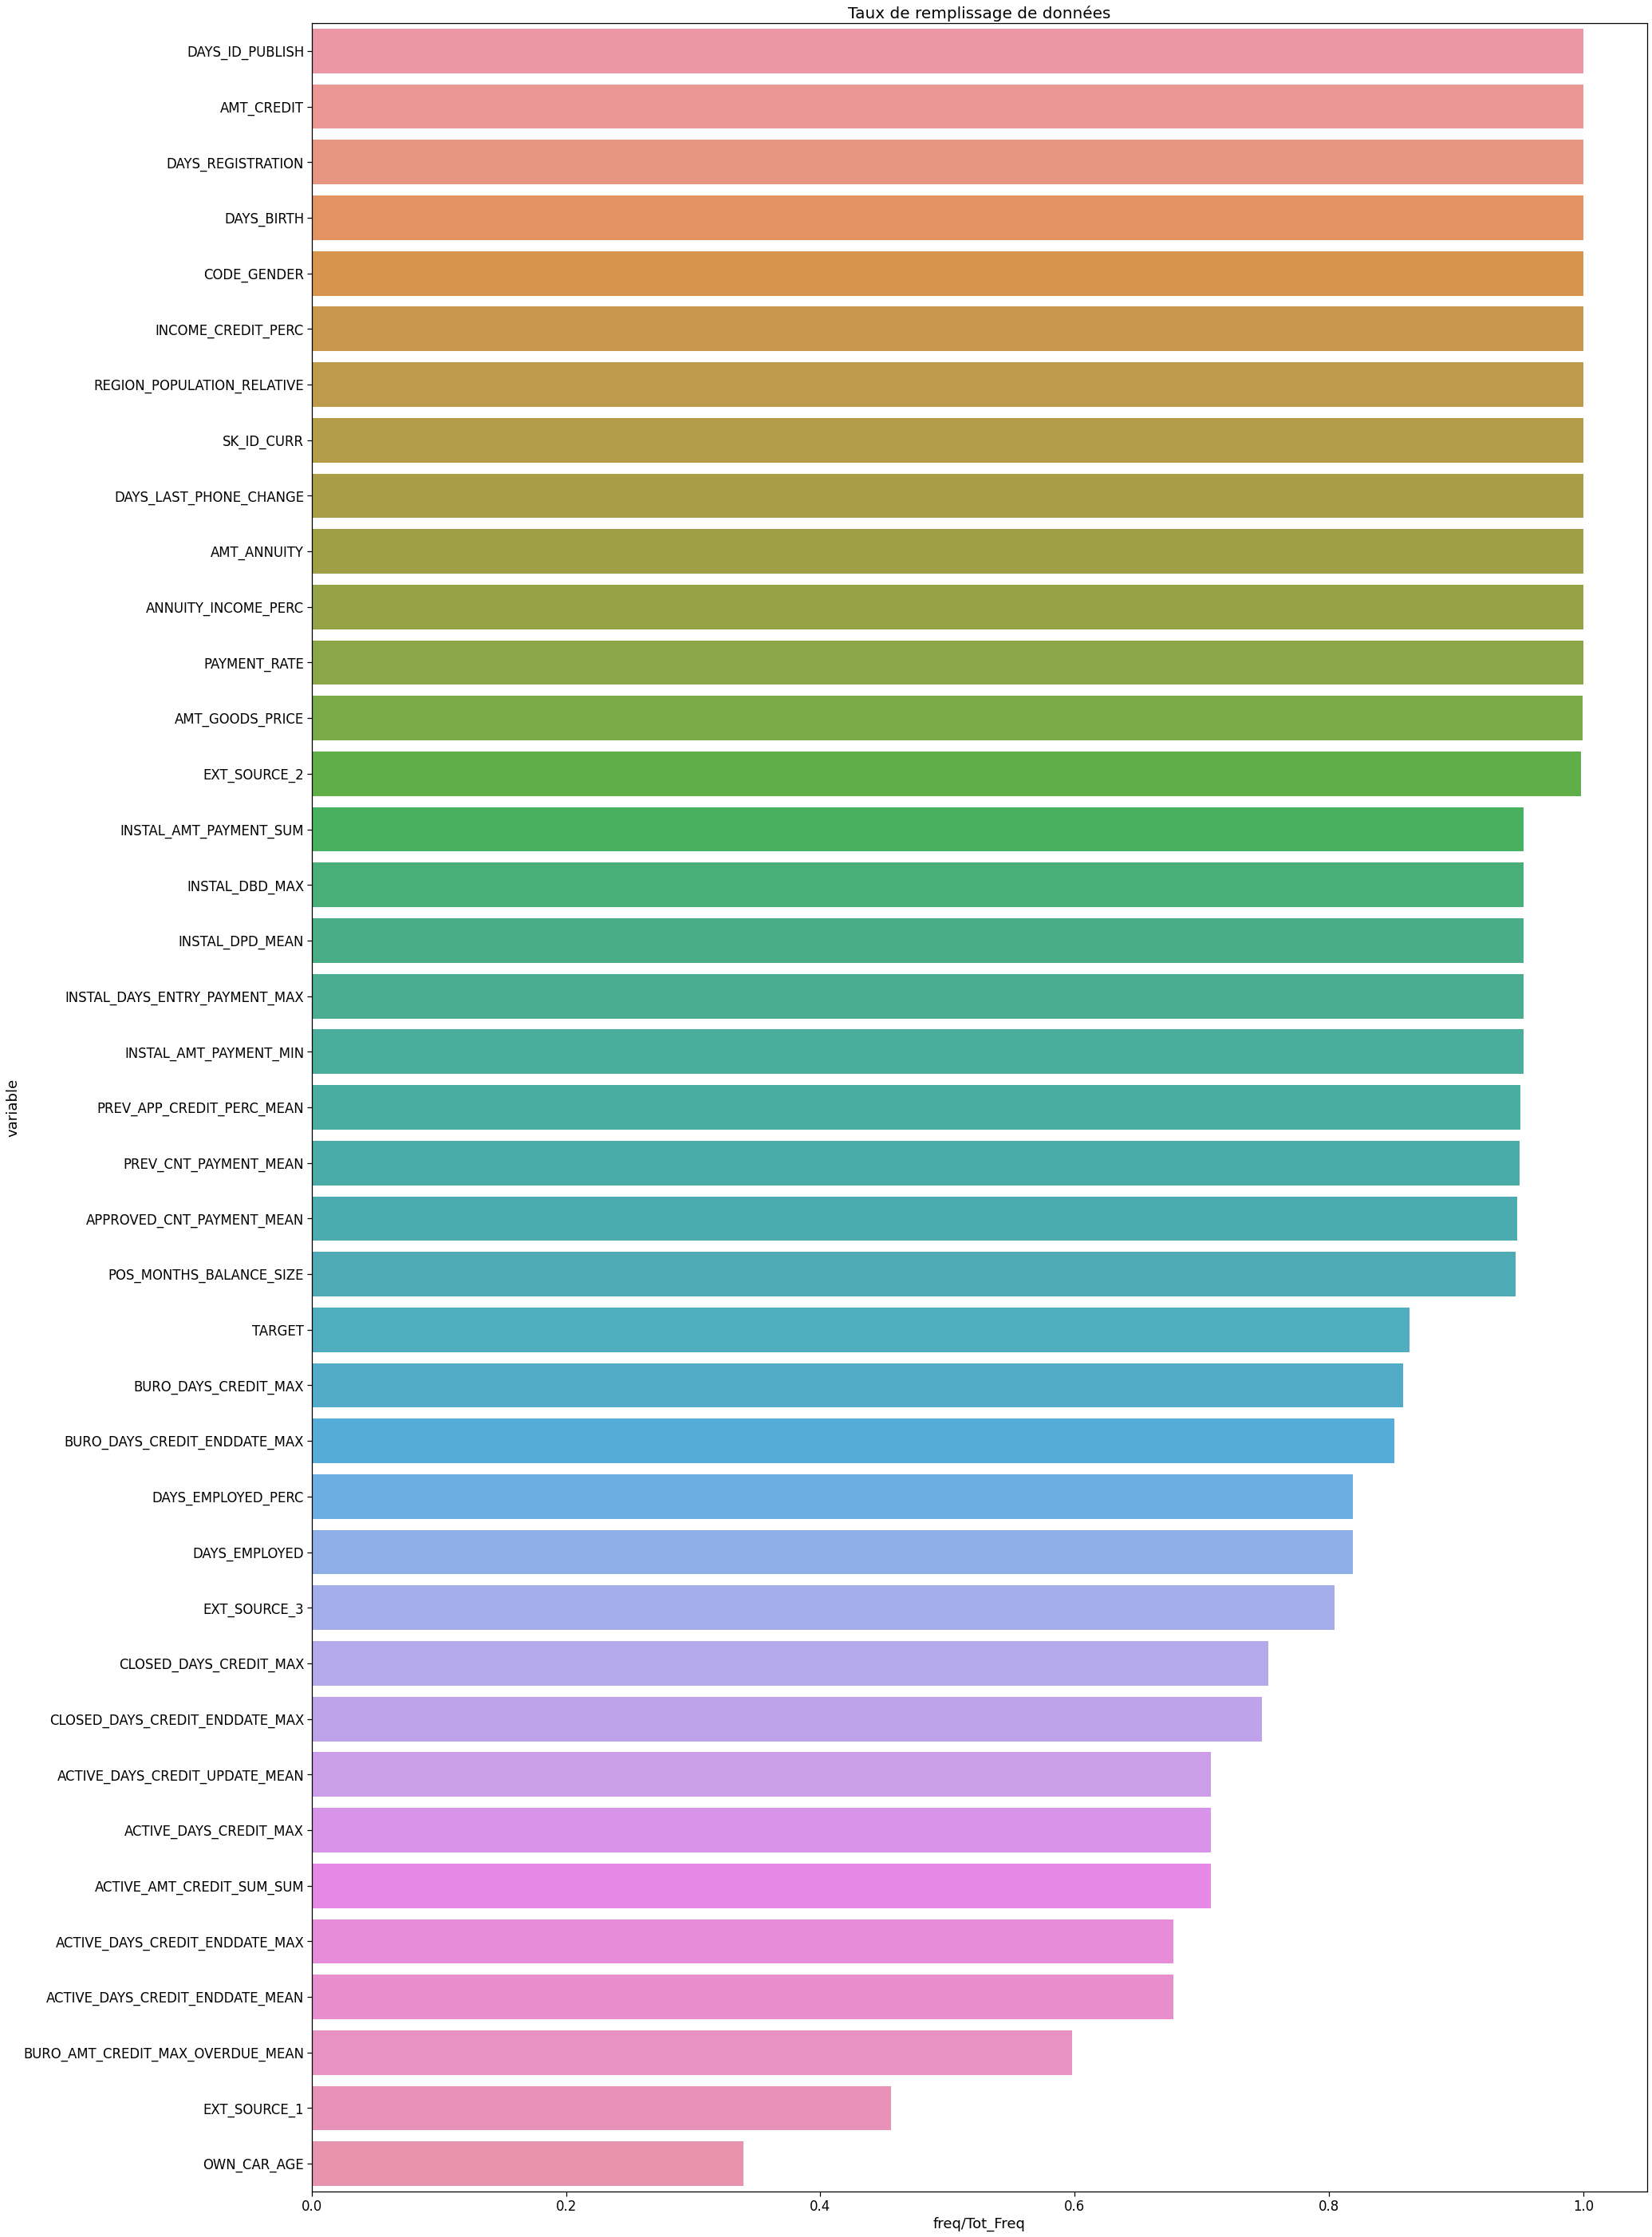

In [90]:
plt.figure(figsize = (30,50))
sns.set_context("notebook", font_scale=1.5)
s1 = sns.barplot(y = 'variable', x = 'freq/Tot_Freq', data = df_taux_values.sort_values(by=['freq'], ascending=False))
plt.title("Taux de remplissage de données", size=20)
plt.show()

In [91]:
df_taux_values_sort = df_taux_values.sort_values(by = 'freq', ascending=False)

In [92]:
df_taux_values_sort['variable'].to_list()

['DAYS_ID_PUBLISH',
 'AMT_CREDIT',
 'DAYS_REGISTRATION',
 'DAYS_BIRTH',
 'CODE_GENDER',
 'INCOME_CREDIT_PERC',
 'REGION_POPULATION_RELATIVE',
 'SK_ID_CURR',
 'DAYS_LAST_PHONE_CHANGE',
 'AMT_ANNUITY',
 'ANNUITY_INCOME_PERC',
 'PAYMENT_RATE',
 'AMT_GOODS_PRICE',
 'EXT_SOURCE_2',
 'INSTAL_AMT_PAYMENT_SUM',
 'INSTAL_DBD_MAX',
 'INSTAL_DPD_MEAN',
 'INSTAL_DAYS_ENTRY_PAYMENT_MAX',
 'INSTAL_AMT_PAYMENT_MIN',
 'PREV_APP_CREDIT_PERC_MEAN',
 'PREV_CNT_PAYMENT_MEAN',
 'APPROVED_CNT_PAYMENT_MEAN',
 'POS_MONTHS_BALANCE_SIZE',
 'TARGET',
 'BURO_DAYS_CREDIT_MAX',
 'BURO_DAYS_CREDIT_ENDDATE_MAX',
 'DAYS_EMPLOYED_PERC',
 'DAYS_EMPLOYED',
 'EXT_SOURCE_3',
 'CLOSED_DAYS_CREDIT_MAX',
 'CLOSED_DAYS_CREDIT_ENDDATE_MAX',
 'ACTIVE_DAYS_CREDIT_UPDATE_MEAN',
 'ACTIVE_DAYS_CREDIT_MAX',
 'ACTIVE_AMT_CREDIT_SUM_SUM',
 'ACTIVE_DAYS_CREDIT_ENDDATE_MAX',
 'ACTIVE_DAYS_CREDIT_ENDDATE_MEAN',
 'BURO_AMT_CREDIT_MAX_OVERDUE_MEAN',
 'EXT_SOURCE_1',
 'OWN_CAR_AGE']

In [93]:
ls_keep = df_taux_values_sort['variable'].to_list()[0:29]
ls_keep

['DAYS_ID_PUBLISH',
 'AMT_CREDIT',
 'DAYS_REGISTRATION',
 'DAYS_BIRTH',
 'CODE_GENDER',
 'INCOME_CREDIT_PERC',
 'REGION_POPULATION_RELATIVE',
 'SK_ID_CURR',
 'DAYS_LAST_PHONE_CHANGE',
 'AMT_ANNUITY',
 'ANNUITY_INCOME_PERC',
 'PAYMENT_RATE',
 'AMT_GOODS_PRICE',
 'EXT_SOURCE_2',
 'INSTAL_AMT_PAYMENT_SUM',
 'INSTAL_DBD_MAX',
 'INSTAL_DPD_MEAN',
 'INSTAL_DAYS_ENTRY_PAYMENT_MAX',
 'INSTAL_AMT_PAYMENT_MIN',
 'PREV_APP_CREDIT_PERC_MEAN',
 'PREV_CNT_PAYMENT_MEAN',
 'APPROVED_CNT_PAYMENT_MEAN',
 'POS_MONTHS_BALANCE_SIZE',
 'TARGET',
 'BURO_DAYS_CREDIT_MAX',
 'BURO_DAYS_CREDIT_ENDDATE_MAX',
 'DAYS_EMPLOYED_PERC',
 'DAYS_EMPLOYED',
 'EXT_SOURCE_3']

In [94]:
best_features = best_features[ls_keep]
best_features.shape

(356251, 29)

In [95]:
ls_keep.remove('TARGET')

In [96]:
best_features = best_features.dropna(subset=ls_keep)
best_features.shape

(217979, 29)

In [97]:
Test_df =  best_features[best_features['TARGET'].isnull()]
Test_df.to_csv('/kaggle/working/Test_df.csv') 
Test_df.shape

(31170, 29)

In [98]:
best_features = best_features.dropna(how = 'any')
best_features.shape

(186809, 29)

In [99]:
Y = best_features[['TARGET']]

In [100]:
Y.shape

(186809, 1)

In [101]:
Y.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 186809 entries, 0 to 307506
Data columns (total 1 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   TARGET  186809 non-null  float64
dtypes: float64(1)
memory usage: 2.9 MB


In [102]:
X_w_ID = best_features[ls_keep]

In [103]:
ls_keep.remove('SK_ID_CURR')

In [104]:
X = best_features[ls_keep]

In [84]:
X.shape

(186809, 27)

In [85]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 186809 entries, 0 to 307506
Data columns (total 27 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   DAYS_ID_PUBLISH                186809 non-null  int64  
 1   AMT_CREDIT                     186809 non-null  float64
 2   DAYS_REGISTRATION              186809 non-null  float64
 3   DAYS_BIRTH                     186809 non-null  int64  
 4   CODE_GENDER                    186809 non-null  int64  
 5   INCOME_CREDIT_PERC             186809 non-null  float64
 6   REGION_POPULATION_RELATIVE     186809 non-null  float64
 7   DAYS_LAST_PHONE_CHANGE         186809 non-null  float64
 8   AMT_ANNUITY                    186809 non-null  float64
 9   ANNUITY_INCOME_PERC            186809 non-null  float64
 10  PAYMENT_RATE                   186809 non-null  float64
 11  AMT_GOODS_PRICE                186809 non-null  float64
 12  EXT_SOURCE_2                  

df.to_csv('/kaggle/working/df.csv')
best_features.to_csv('/kaggle/working/best_features.csv') 

In [24]:
#Y = np.ravel(Y)

In [105]:
X_w_ID.to_csv('/kaggle/working/X_w_ID.csv')

In [27]:
X.to_csv('/kaggle/working/X.csv')

In [28]:
Y.to_csv('/kaggle/working/Y.csv')

# <a name ="MODEL"> MODEL </a>

In [8]:

    
clf = LGBMClassifier(
    nthread=4,
    n_estimators=10000,
    learning_rate=0.02,
    num_leaves=34,
    colsample_bytree=0.9497036,
    subsample=0.8715623,
    max_depth=8,
    reg_alpha=0.041545473,
    reg_lambda=0.0735294,
    min_split_gain=0.0222415,
    min_child_weight=39.3259775,
    silent=-1,
    verbose=-1, 
    class_weight ='balanced',)

ftwo_scorer = make_scorer(fbeta_score, beta=10)   #verifier si pas 0.1
grid = cross_val_score(clf, X, Y, cv=3,scoring=ftwo_scorer)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.


[LightGBM] [Warning] num_threads is set with nthread=4, will be overridden by n_jobs=-1. Current value: num_threads=-1


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.


[LightGBM] [Warning] num_threads is set with nthread=4, will be overridden by n_jobs=-1. Current value: num_threads=-1


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.


[LightGBM] [Warning] num_threads is set with nthread=4, will be overridden by n_jobs=-1. Current value: num_threads=-1


In [9]:
print("%0.2f FBeta Score with a standard deviation of %0.2f" % (grid.mean(), grid.std()))

0.32 FBeta Score with a standard deviation of 0.01


In [21]:
clf.fit(X,Y, eval_metric= ftwo_scorer) # A LANCER 

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.


[LightGBM] [Warning] num_threads is set with nthread=4, will be overridden by n_jobs=-1. Current value: num_threads=-1


LGBMClassifier(class_weight='balanced', colsample_bytree=0.9497036,
               learning_rate=0.02, max_depth=8, min_child_weight=39.3259775,
               min_split_gain=0.0222415, n_estimators=10000, nthread=4,
               num_leaves=34, reg_alpha=0.041545473, reg_lambda=0.0735294,
               silent=-1, subsample=0.8715623, verbose=-1)

In [40]:
filename = 'classic_model.sav'
joblib.dump(clf, filename)

['classic_model.sav']

In [14]:
clf = joblib.load('/kaggle/input/classic-model/classic_model.sav')

In [15]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import fbeta_score
p = precision_score(Y, clf.predict(X))
r = recall_score(Y, clf.predict(X))
f = fbeta_score(Y, clf.predict(X), beta=10)
print('Result: p=%.3f, r=%.3f, f=%.3f' % (p, r, f))

Result: p=0.566, r=0.996, f=0.989


best_features = pd.read_csv('/kaggle/working/best_features.csv')
best_features = best_features.drop(columns = ['Unnamed: 0'])

from imblearn.pipeline import Pipeline
model = Pipeline([
        ('sampling', SMOTE()),
        ('classification', LogisticRegression())
    ])

grid = GridSearchCV(model, params, ...)
grid.fit(X, y)

In [9]:
from imblearn.over_sampling import SMOTE 
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X, Y)

In [10]:
clf = LGBMClassifier(
    nthread=4,
    n_estimators=10000,
    learning_rate=0.02,
    num_leaves=34,
    colsample_bytree=0.9497036,
    subsample=0.8715623,
    max_depth=8,
    reg_alpha=0.041545473,
    reg_lambda=0.0735294,
    min_split_gain=0.0222415,
    min_child_weight=39.3259775,
    silent=-1,
    verbose=-1,)

ftwo_scorer = make_scorer(fbeta_score, beta=10)
grid = cross_val_score(clf, X_res, y_res, cv=3,scoring=ftwo_scorer)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.


[LightGBM] [Warning] num_threads is set with nthread=4, will be overridden by n_jobs=-1. Current value: num_threads=-1


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.


[LightGBM] [Warning] num_threads is set with nthread=4, will be overridden by n_jobs=-1. Current value: num_threads=-1


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.


[LightGBM] [Warning] num_threads is set with nthread=4, will be overridden by n_jobs=-1. Current value: num_threads=-1


In [221]:
print("%0.2f accuracy with a standard deviation of %0.2f" % (grid.mean(), grid.std()))

0.91 accuracy with a standard deviation of 0.13


RANDOM FOREST

In [22]:
from sklearn.ensemble import RandomForestClassifier

clf_rf  = RandomForestClassifier(max_depth=8, random_state=0, class_weight ='balanced')
clf_rf.fit(X, np.ravel(Y))

RandomForestClassifier(class_weight='balanced', max_depth=8, random_state=0)

In [27]:
from sklearn.metrics import precision_score
score = precision_score(Y, clf_rf.predict(X))
score

0.19098193954353457

In [28]:
from sklearn.metrics import recall_score
score = recall_score(Y, clf_rf.predict(X))
score

0.700388857015363

In [31]:
from sklearn.metrics import fbeta_score
f = fbeta_score(Y, clf_rf.predict(X), beta=10)
f

0.6823682273529744

In [26]:
X_res.shape

(342244, 27)

In [27]:
y_res.shape

(342244, 1)

In [11]:
clf.fit(X_res, y_res)
# save the model to disk
filename = 'SMOTE_model.sav'
joblib.dump(clf, filename)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.


[LightGBM] [Warning] num_threads is set with nthread=4, will be overridden by n_jobs=-1. Current value: num_threads=-1


['SMOTE_model.sav']

In [10]:
import joblib
clf_smote = joblib.load('/kaggle/input/model-ocp7/SMOTE_model-2.sav')

In [66]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import fbeta_score
p = precision_score(Y, clf_smote.predict(X))
r = recall_score(Y, clf_smote.predict(X))
f = fbeta_score(Y, clf_smote.predict(X), beta=10)
print('Result: p=%.3f, r=%.3f, f=%.3f' % (p, r, f))

Result: p=0.969, r=0.374, f=0.376


Load X_res et y_res

In [8]:
X = pd.read_csv('/kaggle/input/model-data/X.csv')
X = X.drop(columns = ['Unnamed: 0'])
X.shape

(186809, 27)

In [6]:
Y = pd.read_csv('/kaggle/input/model-data/Y.csv')
Y = Y.drop(columns = ['Unnamed: 0'])
#Y = np.ravel(Y)
Y.shape

(186809, 1)

In [7]:
X_w_ID = pd.read_csv('/kaggle/input/x-w-id/X_w_ID.csv')
X_w_ID = X_w_ID.drop(columns = ['Unnamed: 0'])
#Y = np.ravel(Y)
X_w_ID.shape

(186809, 28)

In [9]:
Train_df = X_w_ID.join(Y)
Train_df = Train_df.set_index('SK_ID_CURR')

In [11]:
Train_df.to_csv('/kaggle/working/Train_df.csv')

Evaluer le modele 

In [6]:
Y['TARGET']

0         1.0
1         0.0
2         0.0
3         0.0
4         0.0
         ... 
186804    0.0
186805    0.0
186806    0.0
186807    1.0
186808    0.0
Name: TARGET, Length: 186809, dtype: float64

Upload Test_df

In [13]:
Test_df = pd.read_csv('/kaggle/input/model-data/Test_df.csv')
Test_df = Test_df.drop(columns = ['Unnamed: 0','TARGET'])

ls_SK_ID = Test_df['SK_ID_CURR'].to_list()

In [13]:
def count_plot(df):
    fig, ax = plt.subplots(figsize=(5,5))
    sns.countplot(data=df, x = df.TARGET)
    return fig

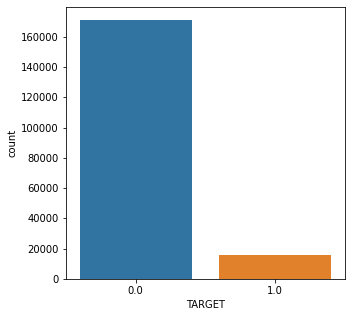

In [18]:
fig0 = count_plot(Y)

In [43]:
def Predict_proba(i,clf, Test_df):
    Test_dfi = Test_df.loc[Test_df.SK_ID_CURR == i]
    Test_dfi = Test_dfi.drop(columns = ['SK_ID_CURR'])
    d = {}
    d['Accept'] = clf.predict_proba(Test_dfi)[0][0]
    d['Refuse'] = clf.predict_proba(Test_dfi)[0][1]
    return d

In [80]:
def Shap_Func( clf, Test_df):
    explainer = shap.Explainer(clf)
    Test_dfi = Test_df.drop(columns = ['SK_ID_CURR'])
    shap_values = explainer(Test_dfi)
    #shap_values.shape 
    return shap_values

In [64]:
i = random.choice(ls_SK_ID)
d=Predict_proba(i,clf_smote,Test_df)
d

{'Accept': 0.9456820721336968, 'Refuse': 0.054317927866303205}

In [45]:
print(i)

218699


CLASSIC MODEL

In [47]:
from sklearn.metrics import confusion_matrix

matrix = confusion_matrix(y_true=Y, y_pred=clf.predict(X))
print(matrix)

[[159143  11979]
 [    58  15629]]


<AxesSubplot:>

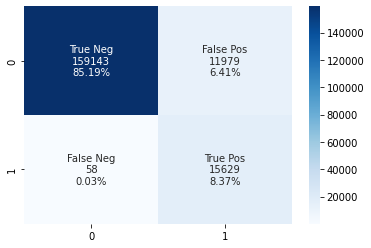

In [54]:
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     matrix.flatten()/np.sum(matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(matrix, annot=labels, fmt='', cmap='Blues')

In [71]:
from sklearn.metrics import confusion_matrix

matrix = confusion_matrix(y_true=y_res, y_pred=clf.predict(X_res))
print(matrix)

[[159143  11979]
 [ 56497 114625]]


<AxesSubplot:>

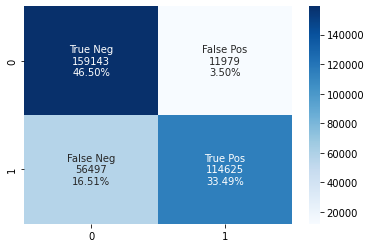

In [72]:
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     matrix.flatten()/np.sum(matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(matrix, annot=labels, fmt='', cmap='Blues')

MODEL SMOTE

In [66]:
from sklearn.metrics import confusion_matrix

matrix_smote = confusion_matrix(y_true=Y, y_pred=clf_smote.predict(X))
print(matrix_smote)

[[170937    185]
 [  9823   5864]]


<AxesSubplot:>

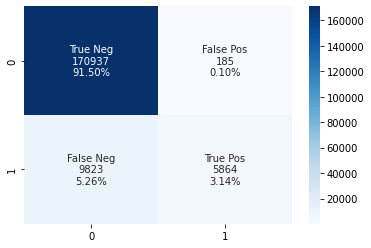

In [67]:
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                matrix_smote.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     matrix_smote.flatten()/np.sum(matrix_smote)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(matrix_smote, annot=labels, fmt='', cmap='Blues')

In [23]:
from sklearn.metrics import confusion_matrix

matrix_random_forest = confusion_matrix(y_true=Y, y_pred=clf_rf.predict(X))
print(matrix_random_forest)

[[124580  46542]
 [  4700  10987]]


<AxesSubplot:>

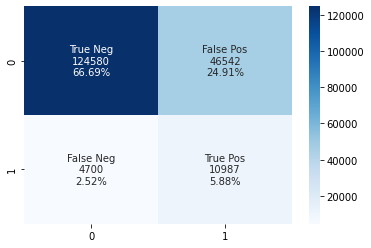

In [24]:
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                matrix_random_forest.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     matrix_random_forest.flatten()/np.sum(matrix_random_forest)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(matrix_random_forest, annot=labels, fmt='', cmap='Blues')

In [7]:
with open( '/kaggle/input/shap-pickle/shap.pickle', 'rb') as handle:
    unserialized_data = pickle.load(handle)

In [8]:
unserialized_data.shape

(31170, 27, 2)

In [9]:
unserialized_data.base_values[10]

array([-1.1696483,  1.1696483])

In [10]:
unserialized_data.values[10][:,0]

array([ 0.3558487 ,  0.32964326,  1.43302658,  0.0228775 ,  0.39546377,
        0.11802425,  1.36203166, -0.09193684,  0.07033144,  1.07877623,
        0.1800602 , -0.39547852, -0.08919456, -0.39751843,  0.70733685,
       -0.32714315, -0.03934394, -0.09782315,  0.19737154,  0.08850351,
        0.61477787,  0.0245473 , -0.02958425, -0.04714721, -0.12343334,
        0.01274076, -0.16899291])

In [47]:
Test_dfi = Test_df.drop(columns = ['SK_ID_CURR'])
Df_Link_ID_Index = Test_df['SK_ID_CURR']
Df_Link_ID_Index = Df_Link_ID_Index.to_frame()
#Df_Link_ID_Index.reset_index(inplace = True)
Df_Link_ID_Index

SK_ID_CURR
0          100001
1          100005
2          100013
3          100028
4          100042
...           ...
31165      456202
31166      456221
31167      456223
31168      456224
31169      456250

[31170 rows x 1 columns]

# <a name ="Local_Interpretation"> Local Interpretation </a>

entrez ID :  100028


3


<AxesSubplot:xlabel='Values', ylabel='Col_names'>

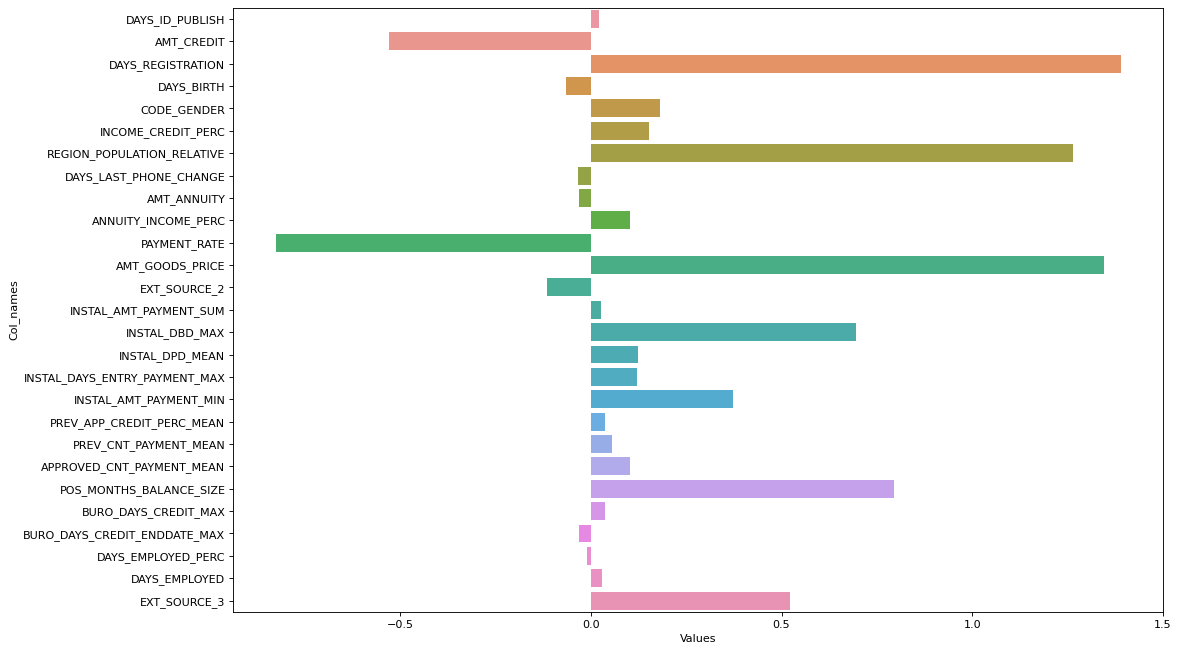

In [63]:
ID = input('entrez ID : ')
i = Df_Link_ID_Index.loc[Df_Link_ID_Index.SK_ID_CURR == int(ID)]
print(i.index[0])
shap_df = pd.DataFrame(unserialized_data.values[i.index[0]][:,0], index = Test_dfi.columns)
shap_df.reset_index(inplace = True)
shap_df.rename(columns={0: "Values", 'index': 'Col_names'}, inplace = True)
fi
sns.barplot(data=shap_df, x=shap_df["Values"], y='Col_names')

Interpretabilité : 

In [27]:
import lime
from lime import lime_tabular

explainer = lime_tabular.LimeTabularExplainer(
    training_data=np.array(X_res),
    feature_names=X_res.columns,
    class_names=['OK', 'Not OK'],
    mode='classification'
)

In [28]:
exp = explainer.explain_instance(
    data_row=X_res.iloc[1], 
    predict_fn=clf.predict_proba
)

exp.show_in_notebook(show_table=True)

In [29]:
y_res.iloc[1]

TARGET    0.0
Name: 1, dtype: float64

In [30]:

exp = explainer.explain_instance(
    data_row=X_res.iloc[0], 
    predict_fn=clf.predict_proba
)

exp.show_in_notebook(show_table=True)

In [31]:
y_res.iloc[0]

TARGET    1.0
Name: 0, dtype: float64

Shap

In [32]:
import shap
explainer = shap.Explainer(clf)

In [37]:
X100 = X_res.sample(n=10)
#X100 = np.ravel(X100)

In [38]:
X100.shape

(10, 27)

In [39]:
shap_values = explainer(X100) #faire sur sample 100 et 1

In [45]:
shap_values.shape

(10, 27, 2)

Permutation explainer: 11it [01:00,  6.75s/it]                        


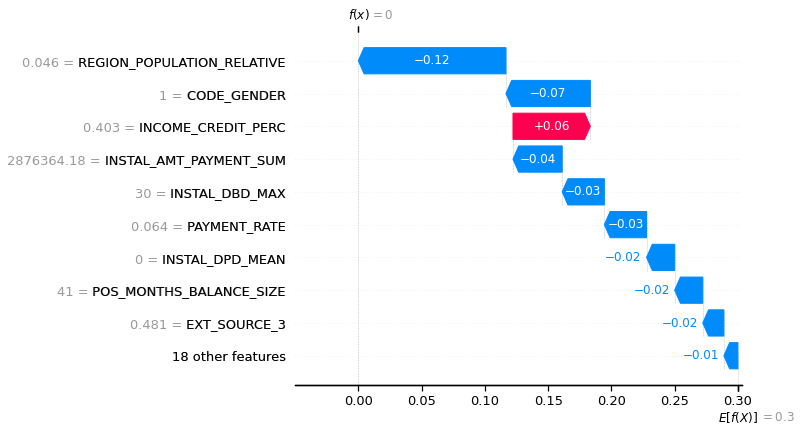

In [58]:
explainer = shap.Explainer(clf.predict, X100)
sv = explainer(X100)

idx = 3
exp = shap.Explanation(sv.values, sv.base_values[0], sv.data, feature_names=X100.columns)
shap.plots.waterfall(exp[idx])

In [ ]:
with open('/kaggle/working/shap_pickle_', 'wb') as handle:
    pickle.dump(shap_values_, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
with open( '/kaggle/input/shap-pickle/shap_pickle_', 'rb') as handle:
    shap_pickle_ = pickle.load(handle)

In [ ]:
idx = 3
exp = shap.Explanation(shap_pickle_.values, shap_pickle_.base_values[0], shap_pickle_.data, feature_names=Test_dfi.columns)
shap.plots.waterfall(exp[idx])